In [1]:
!fusermount -u /content/drive

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CS 7643/final_project/AdaBins"

Mounted at /content/drive
/content/drive/MyDrive/CS 7643/final_project/AdaBins


In [72]:
import os
import cv2
import glob
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm

# Paths
TRAIN_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train/"
VAL_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/val/"
DEPTH_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth/"

OUT_RGB_TRAIN = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_no/"
OUT_RGB_VAL = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/val_no/"
OUT_DEPTH = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth_no/"

#os.makedirs(OUT_RGB_TRAIN, exist_ok=True)
#os.makedirs(OUT_RGB_VAL, exist_ok=True)
#os.makedirs(OUT_DEPTH, exist_ok=True)

# Filtering parameters
border_width = 50  # pixels

def has_earth_border(img, threshold=10):
    """Returns True if any pixel in the border is non-black (above threshold)."""
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[:border_width, :] = 1
    mask[-border_width:, :] = 1
    mask[:, :border_width] = 1
    mask[:, -border_width:] = 1
    border_pixels = img[mask == 1]
    return np.any(border_pixels > threshold)

# === Filter training images (with depth)
depth_files = sorted(glob.glob(f"{DEPTH_DIR}/*.png"))
print("Filtering training images...")
for depth_path in tqdm(depth_files, desc="Train"):
    filename = Path(depth_path).name
    img_train_path = os.path.join(TRAIN_DIR, filename)

    if os.path.exists(img_train_path):
        img = cv2.imread(img_train_path)
        if img is None:
            continue

        if has_earth_border(img):
            continue  # Earth detected, skip

        # Save clean RGB and Depth
        shutil.copy(img_train_path, os.path.join(OUT_RGB_TRAIN, filename))
        shutil.copy(depth_path, os.path.join(OUT_DEPTH, filename))

# === Filter validation images (with depth)
val_files = sorted(glob.glob(f"{VAL_DIR}/*.png"))
print("Filtering validation images...")
for img_val_path in tqdm(val_files, desc="Val"):
    filename = Path(img_val_path).name
    depth_val_path = os.path.join(DEPTH_DIR, filename)

    img = cv2.imread(img_val_path)
    if img is None:
        continue

    if has_earth_border(img):
        continue  # Earth detected, skip

    # Save clean RGB and corresponding Depth
    shutil.copy(img_val_path, os.path.join(OUT_RGB_VAL, filename))
    shutil.copy(depth_val_path, os.path.join(OUT_DEPTH, filename))


Filtering training images...


Train: 100%|██████████| 1278/1278 [03:55<00:00,  5.43it/s] 


Filtering validation images...


Val: 100%|██████████| 320/320 [00:15<00:00, 20.11it/s]


In [88]:
import cv2
import numpy as np
import glob
import os
from tqdm import tqdm
from pathlib import Path
import imageio.v2 as imageio
import matplotlib.pyplot as plt


DEPTH_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth_no/"
TRAIN_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_no/"
VAL_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/val_no/"


out_dir_train = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_preprocessed/"
out_dir_val = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/val_preprocessed/"

# Get all depth maps
depth_files = sorted(glob.glob(f"{DEPTH_DIR}/*.png"))

out_dir = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth_preprocessed/"

#augmentation
def warp_image(image, H, cval=0.0):
    if image.ndim == 3:  # RGB
        warped_channels = []
        for i in range(3):
            warped_c = warp(image[:,:,i], H, output_shape=image.shape[:2], cval=cval, preserve_range=True)
            warped_channels.append(warped_c)
        image2 = np.stack(warped_channels, axis=-1)  # (H, W, 3)
    else:  # Single channel (depth)
        image2 = warp(image, H, output_shape=image.shape, cval=cval, preserve_range=True)
    return image2
def build_homography(tx, ty, theta_deg, scale, px, py, image_shape):
    h, w = image_shape
    xc, yc = w / 2, h / 2
    theta = np.deg2rad(theta_deg)
    T_minus = np.array([
        [1, 0, -xc],
        [0, 1, -yc],
        [0, 0, 1]
    ])

    M = np.array([
        [scale * np.cos(theta), -scale * np.sin(theta), tx],
        [scale * np.sin(theta),  scale * np.cos(theta), ty],
        [px, py, 1]
    ])

    T_plus = np.array([
        [1, 0, xc],
        [0, 1, yc],
        [0, 0, 1]
    ])

    H = T_plus @ M @ T_minus
    return H



for depth_path in tqdm(depth_files, desc="Processing depth maps"):
    filename = Path(depth_path).name

    # Depth image
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    depth = np.clip(depth, 5, None)
    inv_depth = 1.0 / depth
    depth_encoded = (inv_depth * 25600).astype(np.uint16)

    # Find matching RGB image
    train_img_path = os.path.join(TRAIN_DIR, filename)
    val_img_path = os.path.join(VAL_DIR, filename)

    if os.path.exists(train_img_path):
        img_path = train_img_path
        out_dir_img = out_dir_train
    elif os.path.exists(val_img_path):
        img_path = val_img_path
        out_dir_img = out_dir_val
    else:
        print(f"Image {filename} not found in train or val. Skipping.")
        continue

    # Load RGB image
    img = cv2.imread(img_path)  # Load in color
    img = img.astype(np.float32) / 255.0  # Normalize [0, 1]

    # === Generate random warp parameters ===
    tx = np.random.uniform(-200, 200)
    ty = np.random.uniform(-200, 200)
    theta_deg = np.random.uniform(-180, 180)
    scale = 1.0
    px = np.random.uniform(-1e-4, 1e-4)
    py = np.random.uniform(-1e-4, 1e-4)

    # === Build homography ===
    H = build_homography(tx, ty, theta_deg, scale, px, py, image_shape=depth_encoded.shape)

    # === Warp both RGB and Depth ===
    depth_new = warp_image(depth_encoded, H, cval=5120)
    depth_new = depth_new.astype(np.uint16)

    img_new = warp_image(img, H, cval=0.0)  # Fill invalid RGB areas with black

    # === Save new depth ===
    out_path_depth = os.path.join(out_dir, filename)
    imageio.imwrite(out_path_depth, depth_new)

    # === Save new RGB image ===
    out_path_img = os.path.join(out_dir_img, filename)
    img_uint8 = (img_new * 255.0).clip(0, 255).astype(np.uint8)
    imageio.imwrite(out_path_img, img_uint8)

















Processing depth maps: 100%|██████████| 974/974 [01:56<00:00,  8.37it/s]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [ ]:
#remove thre alpha channel
import cv2, glob, os
for img_path in glob.glob("/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_preprocessed/*.png"):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img.shape[2] == 4:                      # has alpha
        cv2.imwrite(img_path, img[:, :, :3])   # overwrite with RGB


for img_path in glob.glob("/content/drive/MyDrive/CS 7643/final_project/dataset_DL/val_preprocessed/*.png"):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img.shape[2] == 4:                      # has alpha
        cv2.imwrite(img_path, img[:, :, :3])   # overwrite with RGB



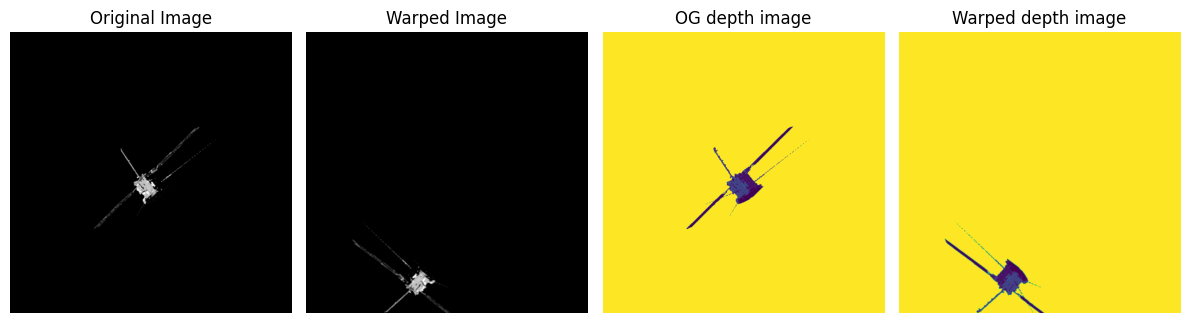

In [41]:
import cv2
import numpy as np
import glob
import os
from pathlib import Path
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import warp


TRAIN_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train/"
DEPTH_DIR = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth_preprocessed/"



#augmentation
def warp_image(image, H, cval = 0.0):
    image2 = warp(image, H, output_shape=image.shape, cval=cval)
    return image2
def build_homography(tx, ty, theta_deg, scale, px, py, image_shape):
    h, w = image_shape
    xc, yc = w / 2, h / 2
    theta = np.deg2rad(theta_deg)
    T_minus = np.array([
        [1, 0, -xc],
        [0, 1, -yc],
        [0, 0, 1]
    ])

    M = np.array([
        [scale * np.cos(theta), -scale * np.sin(theta), tx],
        [scale * np.sin(theta),  scale * np.cos(theta), ty],
        [px, py, 1]
    ])

    T_plus = np.array([
        [1, 0, xc],
        [0, 1, yc],
        [0, 0, 1]
    ])

    H = T_plus @ M @ T_minus
    return H


# === Load one image ===
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))
assert len(train_images) > 0, "No images found in TRAIN_DIR"



img_path = train_images[0]  # Pick first image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0  # Normalize to [0, 1]

depth_images = sorted(glob.glob(f"{DEPTH_DIR}/*.png"))

depth_path = depth_images[0]  # Pick first image

depth = imageio.imread(depth_path).astype('float32') / 256


# === Generate random warp parameters ===
tx = np.random.uniform(-200, 200)          # Translation x (pixels)
ty = np.random.uniform(-200, 200)          # Translation y (pixels)
theta_deg = np.random.uniform(-180, 180)   # Rotation (degrees)
scale = np.random.uniform(1, 1)      # Scaling
px = np.random.uniform(-1e-4, 1e-4)       # Perspective x
py = np.random.uniform(-1e-4, 1e-4)       # Perspective y

# === Build homography and warp ===
H = build_homography(tx=tx, ty=ty, theta_deg=theta_deg, scale=scale, px=px, py=py, image_shape=img.shape)
img_warped = warp_image(img, H, cval = 0.0)
depth_warped = warp_image(depth, H, cval = 20.0)

# === Show Original and Warped ===
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_warped, cmap='gray')
axes[1].set_title('Warped Image')
axes[1].axis('off')


axes[2].imshow(depth)
axes[2].set_title('OG depth image')
axes[2].axis('off')


axes[3].imshow(depth_warped)
axes[3].set_title('Warped depth image')
axes[3].axis('off')

plt.tight_layout()
plt.show()



